# K-means Clustering

## Data PreProcess

In [15]:
import zipfile
import os, glob

def unzip_data(y=2019,m=1,d=1):
    # list all files in folder
    zipfolder = f'/Volumes/LaCie/DocomoMobileData/{y}/{y}{m:02d}{d:02d}'
    zipfiles = sorted(glob.glob(os.path.join(zipfolder, "*.zip")))
    outfolder1 = f'/Volumes/LaCie/DocomoMobileData/{y}_csv'
    outfolder2 = f'/Volumes/LaCie/DocomoMobileData/{y}_csv/{y}{m:02d}{d:02d}'
    if not os.path.exists(outfolder1):
        os.mkdir(outfolder1)
    if not os.path.exists(outfolder2): 
        os.mkdir(outfolder2)
    #extract allfiles
    for f in zipfiles:
        with zipfile.ZipFile(f, 'r') as zip_ref:
            zip_ref.extractall(f'{outfolder2}')

In [16]:
import pandas as pd

def read_data(y=2019,m=1,d=1,type=0):
    """Read one day data and return a dictionary of the day key: hour"""
    outfolder = f'/Volumes/LaCie/DocomoMobileData/{y}_csv/{y}{m:02d}{d:02d}'
    #create csv path and filenames list
    csvfiles = sorted(glob.glob(os.path.join(outfolder, f"*{type}.csv")))
    #read all data
    dfd = {k: pd.read_csv(c) for k, c in enumerate(csvfiles)}
    return dfd

In [42]:
import geopandas as gpd
from shapely.geometry import Point

def read_mesh(path='./Kochi_mesh4.csv'):
    """reads a mesh data with index,centroid,x,y
    creates a DF and Points for geometry to return a
    """
    #read mesh codes
    kochi = pd.read_csv(path,index_col=0)
    kochi['geometry']=[ Point(x,y) for x,y in zip(kochi['X'],kochi['Y'])]
    kochi.drop(columns=['centroid','X','Y'],inplace=True)
    kochi = gpd.GeoDataFrame(kochi,crs="EPSG:4326")
    return kochi

In [83]:
def intersect_data_mesh(df,mesh):
    dfa = df[df['area'].isin(list(mesh['MESH4_ID'].values))]
    dfa = dfa.merge(mesh,left_on='area',right_on='MESH4_ID')
    dfa.drop(columns=['MESH4_ID'],inplace=True)
    return dfa


## Make clusters 

In [77]:
#read some data
dfd = read_data() #whole Japan
kochi = read_mesh() #only an area

In [104]:
#Get a specific hour (h) in the area from the database (dfd) created above
h = 1
df = intersect_data_mesh(dfd[h],kochi)
df.head()


,date,time,area,residence,age,gender,population,geometry
0,20190101,100,503313574,-1,-1,-1,11,POINT (133.47397 33.46550)
1,20190101,100,503313581,-1,-1,-1,24,POINT (133.47915 33.46081)
2,20190101,100,503313583,-1,-1,-1,28,POINT (133.47815 33.46460)
3,20190101,100,503313584,-1,-1,-1,20,POINT (133.48437 33.46459)
4,20190101,100,503313664,-1,-1,-1,43,POINT (133.46215 33.47473)


In [132]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=10, random_state=0, max_iter=100)
lon = df.geometry.map(lambda p: p.x).to_list()
lat = df.geometry.map(lambda p: p.y).to_list() 
X = np.array(pd.DataFrame({'x':lon,'y':lat}))
Y = np.array(df['population'].astype(float))

wt_kmeansclus = kmeans.fit(X, sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)

print(wt_kmeansclus.n_iter_)

df["label"]=wt_kmeansclus.labels_
df.head()

10


,date,time,area,residence,age,gender,population,geometry,label
0,20190101,100,503313574,-1,-1,-1,11,POINT (133.47397 33.46550),9
1,20190101,100,503313581,-1,-1,-1,24,POINT (133.47915 33.46081),9
2,20190101,100,503313583,-1,-1,-1,28,POINT (133.47815 33.46460),9
3,20190101,100,503313584,-1,-1,-1,20,POINT (133.48437 33.46459),9
4,20190101,100,503313664,-1,-1,-1,43,POINT (133.46215 33.47473),9


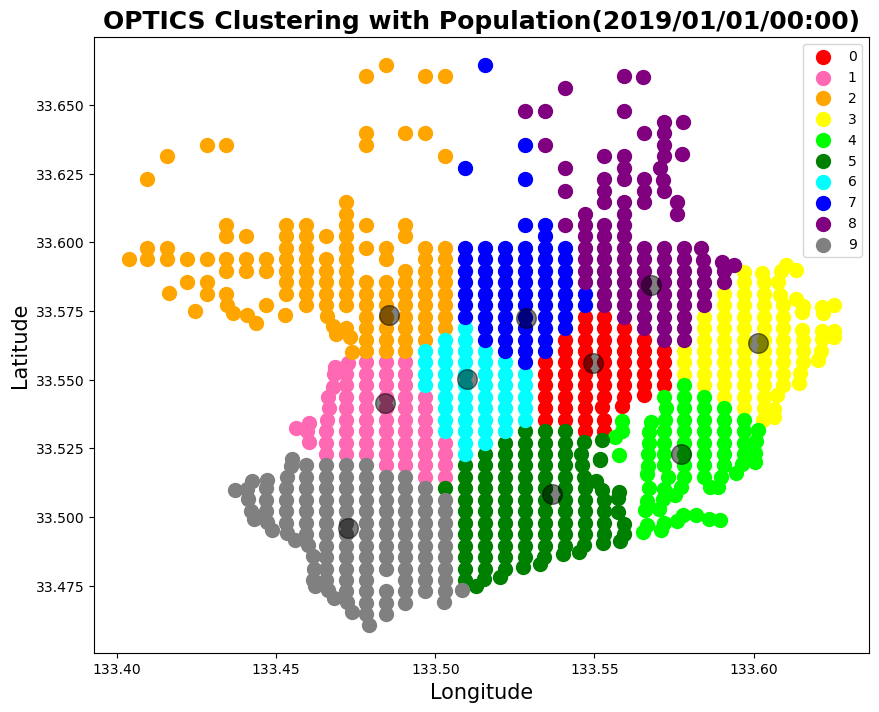

In [133]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(10,8))

color = ['red', 'hotpink', 'orange', 'yellow', 'lime', 'green', 'cyan', 'blue', 'purple', 'grey']
cls_num=10
for cls in range(cls_num):
    clsdata_0 = df[df['label']==cls].copy()
    plt.scatter(clsdata_0.geometry.map(lambda p: p.x).to_list(), clsdata_0.geometry.map(lambda p: p.y).to_list(), s=100, c=color[cls], label=cls)
    
plt.title('OPTICS Clustering with Population(2019/01/01/00:00)', fontsize=18, fontweight='bold')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)

centers = wt_kmeansclus.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.legend()
# def save_fig(y,m,d,h,folder=''):
#     plt.savefig(f"{folder}/{y}{m:02d}{d:02d}{h:02d}_cls10_15.png")
# save_fig(y,m,d,k,folder='./Data/Population_change/figure')

plt.show()

In [134]:
from sklearn.cluster import OPTICS
import numpy as np

db = OPTICS(min_samples=10)
lon = df.geometry.map(lambda p: p.x).to_list()
lat = df.geometry.map(lambda p: p.y).to_list() 
X = np.array(pd.DataFrame({'x':lon,'y':lat}))
Y = np.array(df['population'].astype(float))

db_clus = db.fit(X)
df["label"]=db_clus.labels_
df.head()

,date,time,area,residence,age,gender,population,geometry,label
0,20190101,100,503313574,-1,-1,-1,11,POINT (133.47397 33.46550),-1
1,20190101,100,503313581,-1,-1,-1,24,POINT (133.47915 33.46081),-1
2,20190101,100,503313583,-1,-1,-1,28,POINT (133.47815 33.46460),-1
3,20190101,100,503313584,-1,-1,-1,20,POINT (133.48437 33.46459),-1
4,20190101,100,503313664,-1,-1,-1,43,POINT (133.46215 33.47473),-1


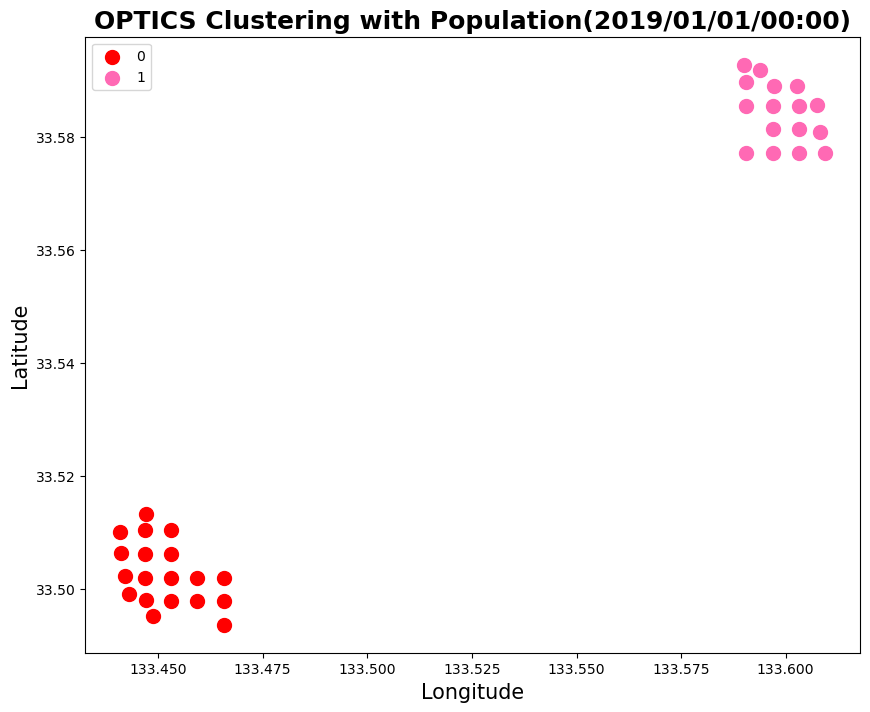

In [135]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(10,8))

color = ['red', 'hotpink', 'orange', 'yellow', 'lime', 'green', 'cyan', 'blue', 'purple', 'grey']
cls_num=2
for cls in range(cls_num):
    clsdata_0 = df[df['label']==cls].copy()
    plt.scatter(clsdata_0.geometry.map(lambda p: p.x).to_list(), clsdata_0.geometry.map(lambda p: p.y).to_list(), s=100, c=color[cls], label=cls)
    
plt.title('OPTICS Clustering with Population(2019/01/01/00:00)', fontsize=18, fontweight='bold')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)

# centers = wt_kmeansclus.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.legend()
# def save_fig(y,m,d,h,folder=''):
#     plt.savefig(f"{folder}/{y}{m:02d}{d:02d}{h:02d}_cls10_15.png")
# save_fig(y,m,d,k,folder='./Data/Population_change/figure')

plt.show()

### エリアごとの時間変化(増減)
- **日付変更あり**
- **時間幅設定変更あり**
- **クラスター数変更あり**

In [34]:
#Y5 = meshdata2['population'].sum()


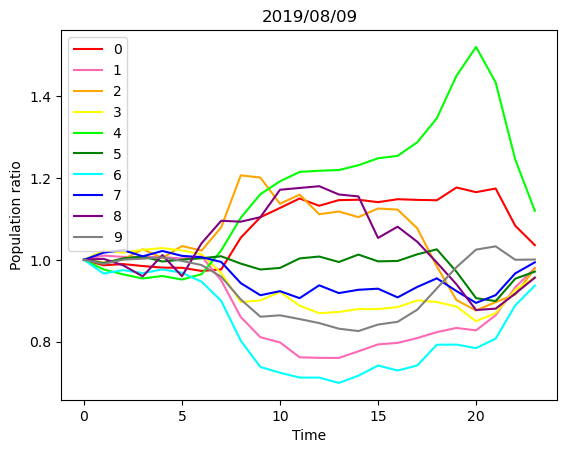

In [5]:
labeldata = clsdata
labeldata = labeldata.drop(['X', 'Y', 'population'], axis=1)


cls_num = 10
roop_num = 24
for cls in range(cls_num): 
    for i in range(roop_num):
        h = k+i
        pref = 39
        mobile = dfd[h][dfd[h]['residence']==pref].copy()
        mobile = mobile.drop(['date', 'time', 'residence', 'age', 'gender'], axis=1)
        mobile = mobile.rename(columns={'area': 'MESH4_ID'})
        join_data = pd.merge(labeldata, mobile[["MESH4_ID",  "population"]], on="MESH4_ID", how="left")
        meshdata = join_data.dropna(subset=['population'])
        meshdata_0 = meshdata[meshdata['label']==cls].copy()
        popsum = meshdata_0['population'].sum()
        data = {
            'time':[h],
            'sum':[popsum],
            'cls':[cls]
        }
        df = pd.DataFrame(data)
        if cls==0 and i==0:
            df.to_csv("./Data/Population_change/Line_graph/population_change.csv", mode='w')
        else:
            df.to_csv("./Data/Population_change/Line_graph/population_change.csv", mode='a', header=False)

            
#color = ['red', 'lime', 'blue', 'grey', 'orange', 'cyan']
color = ['red','hotpink', 'orange', 'yellow', 'lime', 'green', 'cyan', 'blue', 'purple', 'grey']
#color = ['red', 'deeppink', 'hotpink', 'orange', 'yellow', 'lime', 'green', 'cyan', 'blue', 'magenta', 'purple', 'grey']
cls_num = 10
for cls in range(cls_num):
    gd = pd.read_csv("./Data/Population_change/Line_graph/population_change.csv")
    gd_0 = gd[gd['cls']==cls].copy()
    X = gd_0['time']
    Y = gd_0['sum']
    Y2 = gd_0[gd_0['time']==k].copy()
    Y3 = int(Y2['sum'])
    Y4 = Y - Y3
    plt.plot(X, Y4, color=color[cls], label=cls)

plt.title('2019/08/09')
plt.xlabel('Time')
plt.ylabel('Population')
#plt.legend(loc='lower left')
plt.legend(loc='upper left')

def save_fig2(y,m,d,k,folder=''):
    plt.savefig(f"{folder}/{y}{m:02d}{d:02d}{k:02d}_cha10_15.png")
save_fig2(y,m,d,k,folder='./Data/Population_change/figure')

plt.show()

- **日付変更あり**
- **クラスターラベル変更あり**
- **色変更あり**
- **ファイル名変更あり**

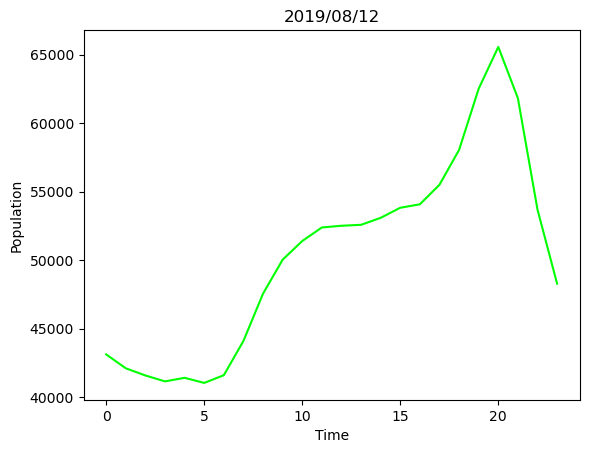

In [97]:
gd = pd.read_csv("./Data/Population_change/Line_graph/population_change.csv")
gd_0 = gd[gd['cls']==4].copy()
plt.plot(gd_0['time'], gd_0['sum'], color='lime')
plt.title("2019/08/12")
plt.xlabel('Time')
plt.ylabel('Population')

def save_fig3(y,m,d,k,folder=''):
    plt.savefig(f"{folder}/{y}{m:02d}{d:02d}{k:02d}_cha_onlyone4_10.png")
#save_fig3(y,m,d,k,folder='./Data/Population_change/figure')

plt.show()

## 絶対値比較
- 日付変更あり

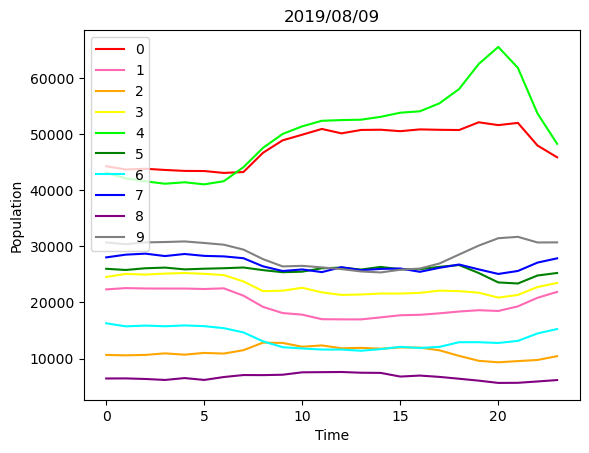

In [6]:
color = ['red','hotpink', 'orange', 'yellow', 'lime', 'green', 'cyan', 'blue', 'purple', 'grey']
cls_num = 10
for cls in range(cls_num):
    gd = pd.read_csv("./Data/Population_change/Line_graph/population_change.csv")
    gd_0 = gd[gd['cls']==cls].copy()
    X = gd_0['time']
    Y = gd_0['sum']
    plt.plot(X, Y, color=color[cls], label=cls)

plt.title('2019/08/09')
plt.xlabel('Time')
plt.ylabel('Population')
#plt.legend(loc='lower left')
plt.legend(loc='upper left')

def save_fig4(y,m,d,k,folder=''):
    plt.savefig(f"{folder}/{y}{m:02d}{d:02d}{k:02d}_cha10_10_15.png")
save_fig4(y,m,d,k,folder='./Data/Population_change/figure')

plt.show()

## 割合比較
- 日付変更あり

In [ ]:
#color = ['red', 'lime', 'blue', 'grey', 'orange', 'cyan']
color = ['red','hotpink', 'orange', 'yellow', 'lime', 'green', 'cyan', 'blue', 'purple', 'grey']
#color = ['red', 'deeppink', 'hotpink', 'orange', 'yellow', 'lime', 'green', 'cyan', 'blue', 'magenta', 'purple', 'grey']
cls_num = 10
for cls in range(cls_num):
    gd = pd.read_csv("./Data/Population_change/Line_graph/population_change.csv")
    gd_0 = gd[gd['cls']==cls].copy()
    X = gd_0['time']
    Y = gd_0['sum']
    Y2 = gd_0[gd_0['time']==k].copy()
    Y3 = int(Y2['sum'])
    Y4 = Y/Y3
    plt.plot(X, Y4, color=color[cls], label=cls)

plt.title('2019/08/09')
plt.xlabel('Time')
plt.ylabel('Population ratio')
#plt.legend(loc='lower left')
plt.legend(loc='upper left')

def save_fig3(y,m,d,k,folder=''):
    plt.savefig(f"{folder}/{y}{m:02d}{d:02d}{k:02d}_ratio10_15.png")
save_fig3(y,m,d,k,folder='./Data/Population_change/figure')

plt.show()